In [1]:
from tqdm import tqdm
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

In [2]:
features = pd.read_parquet('features.parquet')

In [3]:
drop_clmns = ['property_location',
'parcel_number',
'lot',
'current_sales_date',
'assessed_fixtures_value',
'assessed_improvement_value',
'assessed_land_value',
'assessed_personal_property_value',
'the_geom',
'sqft_price',
'home_price']

#     'property_location': 'object',  # part of UID
#     'parcel_number': 'object',  # part of UID
#     'block': 'object',  # part of UID
#     'lot': 'object',  # part of UID

features['idx'] = (
    features.property_location +
    features.parcel_number +
    features.block  +
    features.lot +
    features.week_number.astype('str')
)
features.set_index('idx', inplace=True)
main_feats = pd.read_csv('main_feats.csv').cols.iloc[:50]
data = features.drop(columns=drop_clmns).loc[:, main_feats]

target = features['home_price'] / features.home_price_lag1_roll26_rolling_median
target_sq = features['sqft_price'] / features.sqft_price_lag1_roll26_rolling_median

In [4]:
target_mask = (target_sq > target_sq.quantile(0.05)) & ( target_sq < target_sq.quantile(0.95))
week_mask = data.week_number > 51

data = data.loc[target_mask & week_mask]
target_sq = target_sq.loc[target_mask & week_mask]

In [5]:
cats = [name for name, type_ in data.dtypes.iteritems() if type_ == 'object']
for cat in cats:
    data[cat] = data[cat].astype('category')

cats = [name for name, type_ in data.dtypes.iteritems() if type_ == 'category']
for cat in cats:
    data[cat] = data[cat].cat.codes
data = data.fillna(-999)

In [6]:
years, week_step = 5, 4

start = 51
end = start + 52*years
number_of_steps = (data.week_number.max() - end)//4

In [7]:
week_number = data.week_number
data = data.drop(columns=['week_number','block'])

In [8]:
# subsample_for_bin (int, optional (default=200000)) – Number of samples for constructing bins.
# objective (str, callable or None, optional (default=None)) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below). Default: ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier, ‘lambdarank’ for LGBMRanker.
# class_weight (dict, 'balanced' or None, optional (default=None)) – Weights associated with classes in the form {class_label: weight}. Use this parameter only for multi-class classification task; for binary classification task you may use is_unbalance or scale_pos_weight parameters. Note, that the usage of all these parameters will result in poor estimates of the individual class probabilities. You may want to consider performing probability calibration (https://scikit-learn.org/stable/modules/calibration.html) of your model. The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). If None, all classes are supposed to have weight one. Note, that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.
# min_split_gain (float, optional (default=0.)) – Minimum loss reduction required to make a further partition on a leaf node of the tree.
# min_child_weight (float, optional (default=1e-3)) – Minimum sum of instance weight (hessian) needed in a child (leaf).
# min_child_samples (int, optional (default=20)) – Minimum number of data needed in a child (leaf).
# subsample (float, optional (default=1.)) – Subsample ratio of the training instance.
# subsample_freq (int, optional (default=0)) – Frequency of subsample, <=0 means no enable.
# colsample_bytree (float, optional (default=1.)) – Subsample ratio of columns when constructing each tree.

In [10]:
#Need to refactor this:
# NO FOR LOOPS!

class QRF:
    """
    Use LightGBM quantile regression.
    http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html
    http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html
    """

    def __init__(self, random_state=0, quantile_alphas = [.1, 0.3, .5, 0.7, .9]):
        params = {
            'objective': 'quantile',
            'metric': 'quantile',
        }
        self.quantile_alphas = quantile_alphas
        self.model = {}
        for quantile_alpha in self.quantile_alphas:
            # to train a quantile regression, we change the objective parameter and
            # specify the quantile value we're interested in
            key_ = "QRF_"+str(int(quantile_alpha*100))
            lgb = LGBMRegressor(
                objective='quantile',
                metric='quantile',
                max_depth= 50,
                num_leaves= 200,
                learning_rate= 0.1,
                n_estimators= 1000,
                boosting_type= 'rf',
                alpha=quantile_alpha,
                bagging_freq = 2,
                bagging_fraction = 0.5,
                #colsample_bytree = 0.5
                )
            self.model[key_] = lgb

        print("QRF initialized.")

    def fit(self, X, y):
        for model_key, lgb in self.model.items():
            lgb.fit(X, y)
            # print(f"QGB {model_key} trained.")

    def predict(self, X, quantile=None):
        preds = dict()
        for model_key, lgb in self.model.items():
            preds[model_key]=lgb.predict(X)
        
        return preds  # Probbaly need to concat here?!

    def finetune(self, X_train, y_train):
        """
        LightGBM quantile regression.
            # 'max_depth': 4,
            # 'num_leaves': 15,
            # 'learning_rate': 0.1,
            # 'n_estimators': 100,
            # 'boosting_type': 'gbdt'
        """

        def objective(trial):
            """
            Optuna methods for suggestions:
            suggest_categorical(name, choices)
                Suggest a value for the categorical parameter.
            suggest_discrete_uniform(name, low, high, q)
                Suggest a value for the discrete parameter.
            suggest_float(name, low, high, *[, step, log])
                Suggest a value for the floating point parameter.
            suggest_int(name, low, high[, step, log])
                Suggest a value for the integer parameter.
            suggest_loguniform(name, low, high)
                Suggest a value for the continuous parameter.
            suggest_uniform(name, low, high)
                Suggest a value for the continuous parameter.
            """
            self.cv_results = dict()
            max_depth = trial.suggest_int("max_depth", 4, 30)
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
            # n_estimators = trial.suggest_int("n_estimators", 10, 100)
            for quantile_alpha in self.quantile_alphas:
                # to train a quantile regression, we change the objective parameter and
                # specify the quantile value we're interested in
                model = LGBMRegressor(
                    objective='quantile', metric='quantile',
                    alpha=quantile_alpha, max_depth=max_depth,
                    learning_rate=learning_rate
                    # ,n_estimators=n_estimators
                    )
 
                self.cv_results[quantile_alpha] = cross_validate(model, X_train, y_train, cv=3)

            score = np.mean([
                          cv_results["test_score"].mean() for cv_results
                          in self.cv_results.values()
                          ])

            return score

        self.study = optuna.create_study(direction="minimize")
        self.study.optimize(objective, n_trials=20)
        self.best_params = self.study.best_trials[0].params
        print(f"Best Quantile score: {self.study.best_value}")

        # Look at self.study to get the best validation score
        for model_key, lgb in self.model.items():
            self.model[model_key] = LGBMRegressor(
                objective='quantile',
                metric='quantile',
                max_depth=self.best_params["max_depth"],
                learning_rate=self.best_params["learning_rate"])
                    # , n_estimators=self.best_params["n_estimators"]
    
            self.model[model_key].fit(X_train, y_train)
            # print(f"QGB {model_key} trained.")

        print("QGB finetuned and trained.")

In [11]:
qgb = QRF()

for i in tqdm(range(number_of_steps)):
    
    start = 51 + i*week_step
    end = start + 52*years + i*week_step
    
    train_week_mask = (week_number >= start) & (week_number < end)
    val_week_mask =  (week_number >= end) & (week_number < (end + week_step))
    train_x, val_x = data.loc[train_week_mask], data.loc[val_week_mask]
    train_y, val_y = target_sq.loc[train_week_mask], target_sq.loc[val_week_mask]
        
    if val_x.shape[0] > 0:

        qgb.fit(train_x, train_y)

        pred = qgb.predict(val_x)

        preds_df = pd.DataFrame(pred, index=val_x.index)
        preds_df.to_csv(f'data/qrf/qrf_{i}.csv')
        print(f"step {i} mape {np.mean(np.abs(((pred['QRF_50'] - val_y) / val_y)))}")

QRF initialized.


  0%|                                                                                           | 0/91 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  1%|▉                                                                                | 1/91 [01:11<1:46:32, 71.03s/it]

step 0 mape 0.16730880103273107
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  2%|█▊                                                                               | 2/91 [02:20<1:43:56, 70.07s/it]

step 1 mape 0.16708360123468777
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  3%|██▋                                                                              | 3/91 [03:25<1:39:06, 67.58s/it]

step 2 mape 0.14308054763895037
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  4%|███▌                                                                             | 4/91 [04:37<1:40:56, 69.62s/it]

step 3 mape 0.15122466170507645
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  5%|████▍                                                                            | 5/91 [05:42<1:37:09, 67.79s/it]

step 4 mape 0.13558899220723133
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  7%|█████▎                                                                           | 6/91 [06:49<1:35:38, 67.51s/it]

step 5 mape 0.1397547969956534
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  8%|██████▏                                                                          | 7/91 [07:55<1:33:45, 66.97s/it]

step 6 mape 0.11043471336299883
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


  9%|███████                                                                          | 8/91 [09:18<1:39:47, 72.13s/it]

step 7 mape 0.1444844024122968
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 10%|████████                                                                         | 9/91 [10:24<1:35:54, 70.18s/it]

step 8 mape 0.13430071113703046
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 11%|████████▊                                                                       | 10/91 [11:35<1:35:15, 70.57s/it]

step 9 mape 0.14337847522538694
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 12%|█████████▋                                                                      | 11/91 [12:43<1:33:03, 69.79s/it]

step 10 mape 0.1424853327221244
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 13%|██████████▌                                                                     | 12/91 [13:53<1:31:50, 69.75s/it]

step 11 mape 0.15920922355268036
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 14%|███████████▍                                                                    | 13/91 [15:02<1:30:37, 69.71s/it]

step 12 mape 0.13532500558239063
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 15%|████████████▎                                                                   | 14/91 [16:19<1:32:12, 71.85s/it]

step 13 mape 0.14358505135127353
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 16%|█████████████▏                                                                  | 15/91 [17:31<1:30:54, 71.77s/it]

step 14 mape 0.13252339440085387
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 18%|██████████████                                                                  | 16/91 [18:43<1:29:52, 71.90s/it]

step 15 mape 0.13820254139179605
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 19%|██████████████▉                                                                 | 17/91 [20:00<1:30:32, 73.42s/it]

step 16 mape 0.13913298727174403
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 20%|███████████████▊                                                                | 18/91 [21:10<1:28:04, 72.39s/it]

step 17 mape 0.14303713663180834
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 21%|████████████████▋                                                               | 19/91 [22:19<1:25:33, 71.30s/it]

step 18 mape 0.14218622851070115
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 22%|█████████████████▌                                                              | 20/91 [23:28<1:23:43, 70.76s/it]

step 19 mape 0.14568910185852965
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 23%|██████████████████▍                                                             | 21/91 [24:37<1:21:51, 70.17s/it]

step 20 mape 0.13141838613972084
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 24%|███████████████████▎                                                            | 22/91 [25:45<1:19:54, 69.49s/it]

step 21 mape 0.13266076968089485
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 25%|████████████████████▏                                                           | 23/91 [26:56<1:19:16, 69.94s/it]

step 22 mape 0.14151306702490002
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 26%|█████████████████████                                                           | 24/91 [28:05<1:17:40, 69.56s/it]

step 23 mape 0.12938503730378498
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 27%|█████████████████████▉                                                          | 25/91 [29:12<1:15:46, 68.88s/it]

step 24 mape 0.15554994736614472
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 29%|██████████████████████▊                                                         | 26/91 [30:22<1:14:59, 69.22s/it]

step 25 mape 0.14482294099179918
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 30%|███████████████████████▋                                                        | 27/91 [31:36<1:15:20, 70.63s/it]

step 26 mape 0.155491498111854
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 31%|████████████████████████▌                                                       | 28/91 [32:44<1:13:16, 69.78s/it]

step 27 mape 0.12572505745190396
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 32%|█████████████████████████▍                                                      | 29/91 [33:51<1:11:28, 69.18s/it]

step 28 mape 0.1333034422144486
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 33%|██████████████████████████▎                                                     | 30/91 [35:01<1:10:35, 69.44s/it]

step 29 mape 0.13945546618726576
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 34%|███████████████████████████▎                                                    | 31/91 [36:11<1:09:25, 69.42s/it]

step 30 mape 0.14950824592713002
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 35%|████████████████████████████▏                                                   | 32/91 [37:19<1:07:51, 69.01s/it]

step 31 mape 0.1370418402401644
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 36%|█████████████████████████████                                                   | 33/91 [38:29<1:07:08, 69.45s/it]

step 32 mape 0.1441570374224652
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 37%|█████████████████████████████▉                                                  | 34/91 [39:41<1:06:28, 69.98s/it]

step 33 mape 0.14670023153894973
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 38%|██████████████████████████████▊                                                 | 35/91 [40:51<1:05:25, 70.09s/it]

step 34 mape 0.12747998769148536
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 40%|███████████████████████████████▋                                                | 36/91 [42:06<1:05:29, 71.44s/it]

step 35 mape 0.13148955155579065
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 41%|████████████████████████████████▌                                               | 37/91 [43:19<1:04:57, 72.18s/it]

step 36 mape 0.12823612591123978
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 42%|█████████████████████████████████▍                                              | 38/91 [44:32<1:03:43, 72.15s/it]

step 37 mape 0.1477478079107809
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 43%|██████████████████████████████████▎                                             | 39/91 [45:44<1:02:39, 72.30s/it]

step 38 mape 0.14066664923335062
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 44%|███████████████████████████████████▏                                            | 40/91 [46:58<1:01:51, 72.78s/it]

step 39 mape 0.1400866992101676
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 45%|████████████████████████████████████                                            | 41/91 [48:12<1:00:48, 72.98s/it]

step 40 mape 0.1416949532069131
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 46%|█████████████████████████████████████▊                                            | 42/91 [49:23<59:09, 72.44s/it]

step 41 mape 0.1440225094847392
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 47%|██████████████████████████████████████▋                                           | 43/91 [50:35<57:59, 72.49s/it]

step 42 mape 0.16032757079466708
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 48%|███████████████████████████████████████▋                                          | 44/91 [51:50<57:15, 73.10s/it]

step 43 mape 0.14066996612024857
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 49%|████████████████████████████████████████▌                                         | 45/91 [53:18<59:36, 77.75s/it]

step 44 mape 0.13222080851928666
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


 60%|█████████████████████████████████████████████████▌                                | 55/91 [54:41<08:14, 13.73s/it]

step 45 mape 0.14638750337187711


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [54:42<00:00, 36.07s/it]


In [24]:
preds_df

,QGB_10,QGB_30,QGB_50,QGB_70,QGB_90
idx,,,,,
0000 1382 REVERE AV000047610384761038312,0.709327,0.768153,0.844198,1.021801,1.292888
0000 1017 MENDELL ST000047100704710070312,0.654417,0.756642,0.825409,0.939217,1.210900
0000 0021 REBECCA LN000047200834720083313,0.754744,0.877340,1.003911,1.163208,1.263146
0000 0015 REBECCA LN000047200804720080313,0.764802,0.971855,1.009265,1.129816,1.251631
0000 5900 3RD ST24025431B1225431B122313,0.763106,0.956758,1.025225,1.124211,1.228715
...,...,...,...,...,...
0000 0153 BRONTE ST000056970245697024312,0.801385,1.013457,1.123499,1.206557,1.347129
0000 0555 PRENTISS ST000057290215729021312,0.827797,0.928180,1.034819,1.089882,1.200138
0000 0062 WEST VIEW AV000059000095900009312,0.854371,1.042147,1.132339,1.281334,1.406645


<AxesSubplot:>

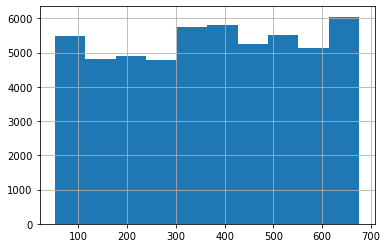

In [29]:
week_number.hist()